# Natural Language Processing r/wallstreetbets and r/investing
## Tyler Zarnik

## Problem Statemant

> I am working with a team on behalf of Reddit.com to find if wallstreetbets is a problematic sub that should be removed from the platform due to hatespeech. We will be comparing this to a subreddit with a very similar focus, r/investing to see if the subreddits can be truly and quickly distinguished from one another based on the laguage used.

## Executive Summary

The goal of this project is to be able to train a model that is able to distinguish posts from two different subreddits where one commonly has hate speech. 

Reddit is a website that often want to present itself as platform for many different types of communities. However, as recent politcal trends have started to become more polarized and even pereptuated by online communities, Reddit is looking to cull this behavior.

Ultimately, we were able to find models that were able to explain 30% more of the posts than a simple null model and tease out the most used words for the subreddits. It also was able to identify some of the most problematic words that specifically and statistically indicated a post from wallstreetbets.

This will  be accomplished by collecting over 5 months of data from the two subreddits. We will use natural language processing libraries to clean through our data sets including stemming and lemmatizing the words. We will concatenate both datasets at the end.In addition, we will clean out any outright profanity and will use the better_profanity library to take out any common profanity or slurs.We will also remove any items that have missing vales in the post title or post description as this will be our primary determining factor.

We will want to employ a model that does have some explanatory power in regards to its features or coefficients, so that the model is able to tease out which words are specific for determining each subreddit. We will overall use: a baseline/ null model, a TFIDF Logistic Regression, a Decision Tree, a Bagged Model, a Randon Forest and a SVC. 

Lastly, we will look to explain our findings and explanatory power of our model in a conclusion, and ultimately recommend that more data and analysis of comment data is needed but that there are glaring issues with speech identified by our model from the subreddit.

### Contents:

- [Data Dictionary](#Data-Dictionary)
- [Imports](#Imports)
- [Data Collection](#Data-Collection)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|df,wsb,inv|Identify Subreddit|
|Title|object|df,wsb,inv|Uncleaned Post Title Data|
|Selftext|object|df,wsb,inv|Uncleaned Post Description Data|
|t_tok|object|df,wsb,inv|Cleaned Tokenized Titles|
|st_tok|object|df,wsb,inv|Clean Tokenized Selftext|
|cleaned_tok|object|df|Concateated from st_tok and t_tok|

## Imports

In [191]:
import pandas as pd
import datetime as dt
import time
import requests
from better_profanity import profanity
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

## Data Collection

Creating query that will be able to take the last 400 days of information. I will most likely later drop some of these rows later by oldest. Since I am able to gather so much data here, I would rather have too many rows and then refine later. Also I forsee most information have a missing value in our festure rows.

In [87]:
# Adapted from Project 3 Intro Author: Boom D. (DSI-NYC), Mahdi Shadkam-Farrokhi (DSI-NYC)

def query_api(subreddit, kind = 'submission', day_window = 2, n = 200):
    SUBFIELDS = ['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 
                 'author_flair_richtext', 'author_flair_text', 'author_flair_type', 'author_fullname',
                 'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post', 'contest_mode', 
                 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta',
                 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 
                 'is_video', 'link_flair_background_color', 'link_flair_richtext', 'link_flair_text_color', 
                 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 
                 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls', 'removed_by_category', 
                 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit', 
                 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'suggested_sort', 'thumbnail', 
                 'title', 'total_awards_received', 'treatment_tags', 
                 'upvote_ratio', 'url', 'whitelist_status', 'wls']
    
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}"
    stem = f"{BASE_URL}?subreddit={subreddit}&size=100" # 100 posts per 2 days
    
    # list to be concatenated
    posts = []
    
    # loop every 5 sconds with time.sleep()
    for i in range(1, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        print("Querying from: " + URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(5)

    full = pd.concat(posts, sort=False)
    
    print("Query Complete!")    
    return full 

In [89]:
df_wsb = query_pushshift('wallstreetbets')

In [ ]:
df_inv = query_pushshift('investing')

After looking through the immense amount of columns available, I am going to limit the number of columns to thoses that I find interesting and potentially useable for EDA and cleaning. The ones that I will most likely look to use however is 'subreddit', 'title',and 'selftext'.

In [90]:
features = ['subreddit','title','score','selftext','author','created_utc','domain','gildings','id','is_self'
            ,'stickied','upvote_ratio','timestamp']

In [ ]:
wsb_df = df_wsb[features]

In [ ]:
inv_df = df_inv[features]

Saving raw data to csv.

In [ ]:
df_wsb.to_csv('./data/df_wsb.csv', index = False)

In [ ]:
df_inv.to_csv('./data/df_inv.csv', index = False)

## Data Cleaning & EDA

In [192]:
df_wsb = pd.read_csv('./data/df_wsb.csv')

df_inv = pd.read_csv('./data/df_inv.csv')

Removing all lines where there is no useful text in selftext. I will probably use this column for modeling and this column potentially has far more words than in the 'title' column.

In [4]:
df_inv = df_inv.loc[df_inv['selftext']!='[removed]']

df_inv = df_inv.loc[df_inv['selftext']!='[deleted]']

df_wsb = df_wsb.loc[df_wsb['selftext']!='[removed]']

df_wsb = df_wsb.loc[df_wsb['selftext']!='[deleted]']

Because I was able to collect so much data, I want to limit my data so that I am able to have models that can execute faster in the modeling and gridsearch phase.

In [5]:
df_inv = df_inv[:3501]

df_wsb = df_wsb[:3500]

In [6]:
df_wsb.reset_index(inplace = True)

df_inv.reset_index(inplace = True)

Creating a profanity filter for the data. All profanity and slurs regardless of length will be represented by .... .This will only be in the WSB data as r/investing is safe for work.

In [7]:
for i in range(len(df_wsb['selftext'])):
    df_wsb['selftext'][i] = profanity.censor(df_wsb['selftext'][i])

for i in range(len(df_wsb['title'])):
    df_wsb['title'][i] = profanity.censor(df_wsb['title'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
wsb = df_wsb[features]

inv = df_inv[features]

Here I am taking out any items that are not characters using regular expressions.

In [9]:
wsb['selftext'] = wsb['selftext'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
for i in range(len(wsb['selftext'])):
    wsb['selftext'][i]= re.sub("[^a-zA-Z]", " ",wsb['selftext'][i]) 


for i in range(len(wsb['title'])):
    wsb['title'][i]= re.sub("[^a-zA-Z]", " ",wsb['title'][i]) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
inv['selftext'] = inv['selftext'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
for i in range(len(inv['selftext'])):
    inv['selftext'][i]= re.sub("[^a-zA-Z]", " ",inv['selftext'][i]) 

for i in range(len(inv['title'])):
    inv['title'][i]= re.sub("[^a-zA-Z]", " ",inv['title'][i]) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Using the word_tokenize method of the nltk library. This will return and clean the words to be lemmatized later.

In [13]:
wsb['st_tok']  =wsb['selftext'].map(word_tokenize)

wsb['t_tok']  =wsb['title'].map(word_tokenize)

inv['st_tok'] = inv['selftext'].map(word_tokenize)

inv['t_tok']=inv['title'].map(word_tokenize)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Lemmatizing words below, this will give the common root of words back. This will ultimately create less rows and equivicate similar words

In [14]:
lem = WordNetLemmatizer()

In [15]:
for i in range(len(wsb['st_tok'])):
    for n in range(len(wsb['st_tok'][i])):
        wsb['st_tok'][i][n] =  lem.lemmatize(wsb['st_tok'][i][n]).lower() 

for i in range(len(wsb['t_tok'])):
    for n in range(len(wsb['t_tok'][i])):
        wsb['t_tok'][i][n] =  lem.lemmatize(wsb['t_tok'][i][n]).lower() 

for i in range(len(inv['st_tok'])):
    for n in range(len(inv['st_tok'][i])):
        inv['st_tok'][i][n] =  lem.lemmatize(inv['st_tok'][i][n]).lower() 

for i in range(len(inv['t_tok'])):
    for n in range(len(inv['t_tok'][i])):
        inv['t_tok'][i][n] =  lem.lemmatize(inv['t_tok'][i][n]).lower() 

for i in range(len(inv['t_tok'])):
    for n in range(len(inv['t_tok'][i])):
        inv['t_tok'][i][n] =  lem.lemmatize(inv['t_tok'][i][n]).lower() 

Creating a new column that is the cleaned and lemmatized 'selftext' and 'title' columns. This will allow me to use more diverse text for the model phase.

In [16]:
inv['cleaned_tok'] = (inv['st_tok'] +inv['t_tok'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
wsb['cleaned_tok'] = (wsb['st_tok'] +wsb['t_tok'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Joining DataFrames to be used as a whole. Another csv checkpoint as well.

In [18]:
df = pd.concat([inv,wsb],join = 'outer',ignore_index = True)

In [193]:
df.to_csv('./data/full_wsb_inv.csv',index = False)

## Preprocessing & Modeling

In [20]:
df = pd.read_csv('./data/full_wsb_inv.csv')

As stated above, will use 'cleaned_tok' as the main column to model.

In [21]:
X = df['cleaned_tok']
y = df['subreddit']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

Before completely starting the modeling process, I want to visualize what are the most common words in our X_train  set. I will look to see the difference in the words that are seen as important by the selected model later if possible.

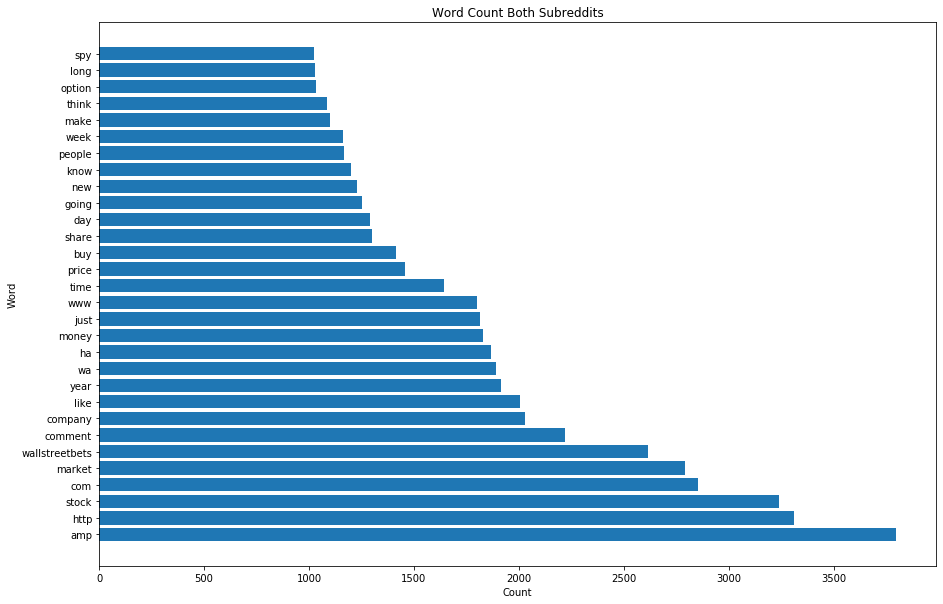

In [189]:
cvec_v = CountVectorizer(stop_words = 'english') 

X_train_v = cvec_v.fit_transform(X_train)

X_train_v = pd.DataFrame(X_train_v.toarray(),
                          columns=cvec_v.get_feature_names())

X_test = cvec_v.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(),
                         columns=cvec_v.get_feature_names())

# get count of top-occurring words

# # empty dictionary
top_words = {}

# # loop through columns
for i in X_train_v.columns:
#     # save sum of each column in dictionary
    top_words[i] =  X_train_v[i].sum()
    
# # top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

plt.figure(figsize = (15, 10))

# visualize top 10 words
plt.barh(most_freq[0][:30], most_freq[1][:30])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Word Count Both Subreddits')
plt.tight_layout;

### Null

Since all of the models are focused on accuracy, our null model is simply going to say that any data is the majority class. In this case, the investing columns has one more row so our data will be split around 50%.

In [23]:
y_test.value_counts(normalize=True)

wallstreetbets    0.5
investing         0.5
Name: subreddit, dtype: float64

## Tfidf LR

In [33]:
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 1000))
])

In [34]:
pipe_tfidf_params = {
    'tfidf__max_features': [5_000,6_000,7000],
    'tfidf__stop_words': [None, 'english'],
    'lr__C': [1,2],

}

In [35]:
gs_tfidf = GridSearchCV(pipe_tfidf, 
                        param_grid = pipe_tfidf_params, 
                        cv=5) 

In [36]:
%%time
gs_tfidf.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 371 ms, total: 1min 5s
Wall time: 29.3 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [37]:
gs_tfidf.best_params_

{'lr__C': 2, 'tfidf__max_features': 6000, 'tfidf__stop_words': None}

In [38]:
gs_tfidf.score(X_train, y_train)

0.9283809523809524

In [39]:
gs_tfidf.score(X_test, y_test)

0.8382857142857143

In [140]:
cross_val_score(gs_tfidf.best_estimator_, X_train, y_train, cv = 5).mean()

0.839047619047619

In [150]:
gs_tfidf.best_estimator_.steps[1][1].coef_.flatten()

array([-0.4356528 ,  0.07568331,  0.01851619, ..., -0.09596178,
        0.00118654,  0.42241922])

## CART

In [41]:
pipe_dt = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english')),
    ('dt' , DecisionTreeClassifier())
])


In [42]:
pipe_dt_params = {
    'dt__max_depth' : [150],
    'dt__min_samples_split' : [10,20],
    'dt__min_samples_leaf' : [1,3],
    'dt__random_state' : [42],
    'dt__max_features' :[150,200]      

}

In [43]:
gs_dt = GridSearchCV(pipe_dt,
                        param_grid = pipe_dt_params,
                        cv=5) 

In [44]:
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [45]:
gs_dt.score(X_train, y_train)

0.8139047619047619

In [46]:
gs_dt.score(X_test, y_test)

0.7131428571428572

In [47]:
gs_dt.best_params_

{'dt__max_depth': 150,
 'dt__max_features': 150,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 20,
 'dt__random_state': 42}

In [48]:
cross_val_score(gs_dt.best_estimator_, X_train, y_train, cv = 5).mean()

0.7081904761904761

#### Bagging

In [73]:
tvec = TfidfVectorizer(stop_words = 'english')
bag = BaggingClassifier()

tvec.fit(X_train)

bag_X_train = tvec.transform(X_train)

bag_X_test = tvec.transform(X_test)

bag_df = pd.DataFrame(bag_X_train.toarray(),
                          columns=tvec.get_feature_names())

bag_df_test = pd.DataFrame(bag_X_test.toarray(),
                          columns=tvec.get_feature_names())

bag.fit(bag_df, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [74]:
bag.score(bag_df, y_train)

0.9801904761904762

In [76]:
bag.score(bag_df_test, y_test)

0.7451428571428571

## Random Forest

In [49]:
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf' , RandomForestClassifier()
    )])


In [50]:
pipe_rf_params = {
    'rf__max_depth' : [75,100],
    'rf__ccp_alpha': [0],
    'rf__n_estimators': [200],
    'tfidf__stop_words' : ['english'],
    

}

In [51]:
gs_rf = GridSearchCV(pipe_rf, 
                        param_grid = pipe_rf_params,
                        cv=5) 

In [52]:
%%time
gs_rf.fit(X_train,y_train)

CPU times: user 50.2 s, sys: 226 ms, total: 50.5 s
Wall time: 50.7 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [53]:
gs_rf.score(X_train,y_train)

0.9860952380952381

In [54]:
gs_rf.score(X_test,y_test)

0.8125714285714286

In [55]:
gs_rf.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': 75,
 'rf__n_estimators': 200,
 'tfidf__stop_words': 'english'}

In [56]:
cross_val_score(gs_rf.best_estimator_, X_train, y_train, cv = 5).mean()

0.8278095238095238

## SVC

In [57]:
pipe_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english')),
    ('svc' , SVC(gamma="scale", C = 5,
    kernel = "rbf"
    ))])


In [58]:
pipe_svc_params = {


}

In [59]:
gs_svc = GridSearchCV(pipe_svc,
                        param_grid = pipe_svc_params, 
                        cv=5)

In [60]:
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [61]:
gs_svc.score(X_train, y_train)

0.9984761904761905

In [62]:
gs_svc.score(X_test, y_test)

0.8411428571428572

In [63]:
cross_val_score(gs_svc.best_estimator_, X_train, y_train, cv = 5).mean()

0.8335238095238097

## Model Selection

| Name | Train Score | Test Score | Cross Val Score |
|---|---|---|---|
| Null Model | 50 | 50 | 50 |
| Tfidf LR | 0.928 | 0.838 | 0.839|
| Cart | 0.813 | 0.713| 0.708 |
| Bagging | 0.980 | 0.745| 0.708 |
| Random Forest| 0.984 | 0.813 | 0.827 |
| SVC | 0.998 | 0.841 | 0.833 |



I have decided to pick my TFIDF Vectorized Logistic Regression model for this evaluation. Although it had a lower test score than the SVC Model, it had lower variance in cross validation scores and lower variance between test and train data. In addition, Logistic regression models allow for us to link our coefficients to our test data which I will be exhibiting below.

## Evaluation and Conceptual Understanding

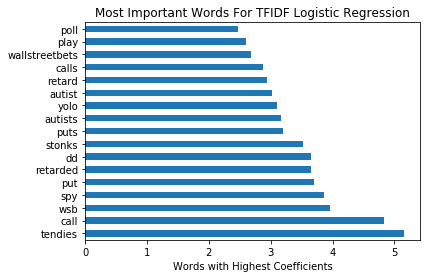

In [166]:
word_df  =pd.DataFrame(gs_tfidf.best_estimator_.steps[1][1].coef_.flatten(),
                        gs_tfidf.best_estimator_.steps[0][1].get_feature_names())
word_df.sort_values(0,ascending = False).head(17).plot(kind = 'barh', legend = False);

plt.title('Most Important Words For TFIDF Logistic Regression');
plt.xlabel('Words with Highest Coefficients');

Even though I have taken out profanity in the model, there are clearly words here that are problematic. Some are of these words are specifically exhibit a glaring amount of mental ableism. 

Other important words that indicate a wallstreetbets post include, tendies, spy, stonks, yolo, and dd. Tendies is a sub specific term to denote gains made on risky stock and options trades. spy is the ticker SPY which many posters commonly trade and is a favorite among the community. Yolo is stands for 'you only live once' a meme that was popular in the 2000s but seems to have traction as an ironic/meta term in the wsb community. dd stands for 'due diligence' which is commonly used at wsb to try and logically reason out usually risky trades before the trade occurs. Stonks is a meme among the community that certain stock 'only go up'.

## Conclusion and Recommendations

While the graph earlier indicated that the most common words used between the subs were innoculus, our model was able to tease out some very problematic results. Despite these words getting through the filter, this would likely indicate that there may be a hostile userbase and hate speech involved here or at the very least extremely distasteful and problematic ways of insulting other users in a joking way. However, joking is always a thinly excuse for that type of behaviour and should rarely if ever be accepted. Our model although not always able to identify the difference between the posts at only an 84 percent accuracy, still performs well above our baseline model of 50 percent. Our model was able to tease out which words and posts are problematic. Our coefficients were also extremly high in many circumstances.

While their is a large amount of evidence here, more would be needed in terms of looking at all user comment data. In addition, we would need to manually review many of these posts that are being teased out by our models. Although this speech is unacceptable, Reddit is a website that tries to maintain an environment that is not inherently toxic but also allowing a certian modicum of a wide array of speech that is also not advocating violence.